In [1]:
import pandas as pd
from prophet import Prophet

c:\Users\srb73\miniconda3\envs\tf\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [30]:
data= pd.read_csv("dataset.csv")

In [31]:
data=data[:48]

In [36]:
# Check for missing values
# print(data.isnull().sum())

# Extract the quarter and year from the 'INDIA quaterly data from 2010 to 2021' column
data['Quarter'] = data['INDIA quaterly data from 2010 to 2021'].str.extract(r'(Q\*\d)')[0].str.replace('*', '')
years = []
for year in range(2010, 2022):
    years.extend([year] * 4)

# Add the 'Year' column to the dataframe
data['Year'] = years




In [ ]:
# Ensure there are no NaN values in 'Quarter' or 'Year'
data = data.dropna(subset=['Quarter', 'Year'])

# Display cleaned data
print(data[['Year', 'Quarter']].head())

In [38]:
# Create a new column 'ds' with the formatted date
data['ds'] = data.apply(lambda row: f"{row['Year']}-{row['Quarter']}", axis=1)
data['ds'] = pd.PeriodIndex(data['ds'], freq='Q').to_timestamp()

# Display the updated data with the date column
print(data[['ds', 'Year', 'Quarter']].head())


          ds  Year Quarter
0 2010-01-01  2010      Q1
1 2010-04-01  2010      Q2
2 2010-07-01  2010      Q3
3 2010-10-01  2010      Q4
4 2011-01-01  2011      Q1


In [43]:
# Convert 'JEWELLRY demand in tonnes' and 'CONSUMER demand in tonnes' to numeric
data['y'] = pd.to_numeric(data['JEWELLRY demand in tonnes'], errors='coerce')
data['consumer_demand'] = pd.to_numeric(data['CONSUMER demand in tonnes'], errors='coerce')

# Drop any rows with NaN in 'y' or 'consumer_demand' after conversion
data = data.dropna(subset=['y', 'consumer_demand'])

# Display the cleaned data
data.head()


,INDIA quaterly data from 2010 to 2021,JEWELLRY demand in tonnes,PRICE (Rs/10gm),CONSUMER demand in tonnes,Quarter,Year,ds,y,consumer_demand
0,Q*1,190.9,"16,369.1",269.4,Q1,2010,2010-01-01,190.9,269.4
1,Q*2,117.3,"17,590.7",177.1,Q2,2010,2010-04-01,117.3,177.1
2,Q*3,166.6,"18,324.4",259.4,Q3,2010,2010-07-01,166.6,259.4
3,Q*4,186.9,"19,708.9",295.8,Q4,2010,2010-10-01,186.9,295.8
4,Q*1,198.8,"20,176.3",298.8,Q1,2011,2011-01-01,198.8,298.8


In [40]:
from prophet import Prophet

# Create the Prophet model
model = Prophet()

# Add the consumer demand as an additional regressor
model.add_regressor('consumer_demand')

# Fit the model to the data
model.fit(data[['ds', 'y', 'consumer_demand']])


13:56:50 - cmdstanpy - INFO - Chain [1] start processing
13:56:50 - cmdstanpy - INFO - Chain [1] done processing


In [42]:
# Define the number of quarters to forecast into the future
future_quarters = 8  # for example, predicting the next 2 years (8 quarters)

# Create a dataframe to hold future dates
future = model.make_future_dataframe(periods=future_quarters, freq='Q')

# For the new quarters, we need to set the consumer demand
# Here we just fill with the mean of the historical data
future['consumer_demand'] = data['consumer_demand'].mean()

# Make predictions
forecast = model.predict(future)

# Display the forecast
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


c:\Users\srb73\miniconda3\envs\tf\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  dates = pd.date_range(


,ds,yhat,yhat_lower,yhat_upper
51,2022-09-30,149.842364,138.344840,161.040214
52,2022-12-31,113.075670,102.191228,123.214527
53,2023-03-31,172.807585,160.898365,184.052293
54,2023-06-30,138.622016,126.865465,150.292209
55,2023-09-30,144.660417,132.742461,155.539552


c:\Users\srb73\miniconda3\envs\tf\lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\srb73\miniconda3\envs\tf\lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


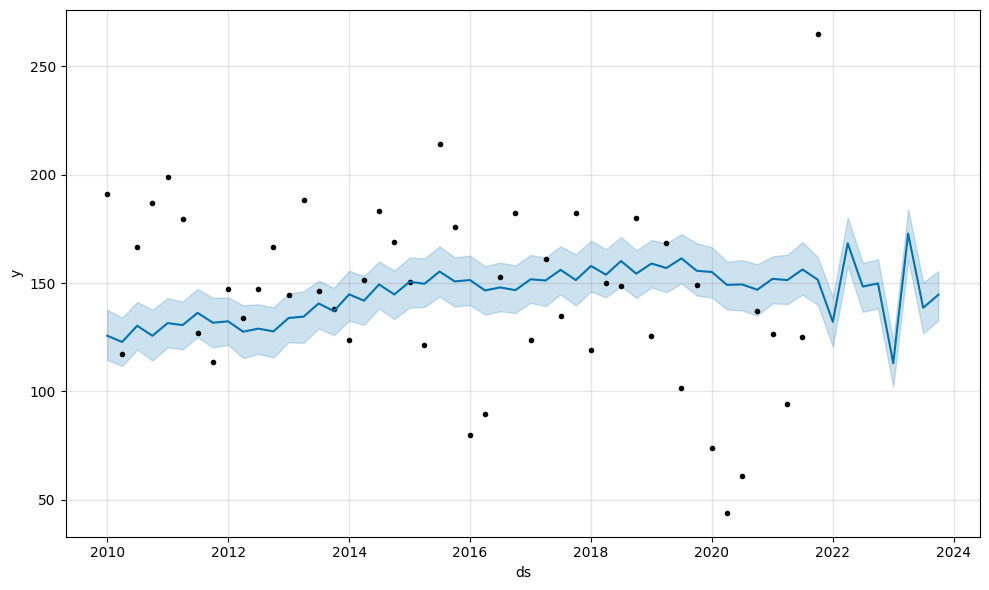

c:\Users\srb73\miniconda3\envs\tf\lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\srb73\miniconda3\envs\tf\lib\site-packages\prophet\plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
c:\Users\srb73\miniconda3\envs\tf\lib\site-packages\prophet\plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain

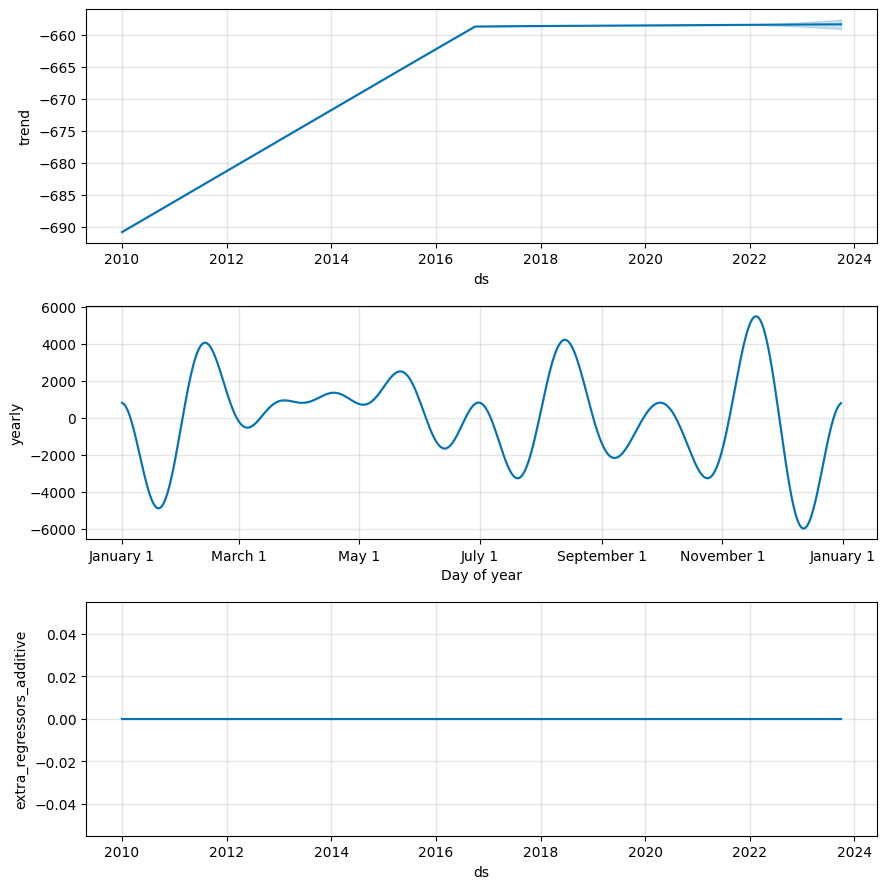

In [44]:
import matplotlib.pyplot as plt

# Plot the forecast
model.plot(forecast)
plt.show()

# Plot the forecast components
model.plot_components(forecast)
plt.show()
